In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from pandas import DataFrame
from pandas import to_datetime
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

import fbprophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio


In [2]:
from plotly.io import write_image

In [3]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [4]:
import chart_studio
chart_studio.tools.set_credentials_file(username='replace', api_key='replace')

In [5]:
chart_studio.tools.set_config_file(world_readable=True,
                             sharing='public')


In [6]:
import chart_studio.plotly as py

In [7]:
data = pd.read_csv('sancionesCnbv.csv')

In [8]:
data.columns = [x.lower() for x in data.columns]

In [9]:
data.columns = data.columns.str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')

In [10]:
data.columns= data.columns.str.replace(' ' ,"_")

In [11]:
data.columns = data.columns.str.strip('_')

In [12]:
data.columns

Index(['id_sancion', 'tipo_de_persona', 'infractor', 'tipo_de_sancion',
       'sub_sector', 'monto', 'entidad_asociada', 'sector_de_entidad_asociada',
       'conducta_sancionada', 'normatividad_infringida',
       'descripcion_de_la_conducta', 'fecha_de_infraccion',
       'fecha_de_imposicion', 'pagada', 'grave', 'reincidente',
       'resolucion_firme', 'susceptible_de_impugnacion', 'mes_de_publicacion',
       'aclaraciones', 'unnamed:_20', 'unnamed:_21', 'unnamed:_22',
       'unnamed:_23'],
      dtype='object')

In [13]:
data = data.rename(columns={'fecha_de_infraccion':'anio_infraccion'})

In [14]:
data['monto'] = data['monto'].astype('str') 
data ["monto"] = data ["monto"].str.extract(r'([\d].*\.\d.)')
data ["monto"] = data ["monto"].str.replace(',', '')
data [['monto']] = data[['monto']].fillna(0).astype(float)

In [15]:
data ['anio_infraccion']=data['anio_infraccion'].astype('string').str.rstrip(".0")

In [16]:
data['anio_infraccion']= pd.to_datetime(data['anio_infraccion'],errors='coerce')

In [17]:
data['fecha_de_imposicion']= pd.to_datetime(data['fecha_de_imposicion'],format='%d/%m/%Y',errors='coerce')



In [18]:
data['anio_imposicion'] = data['fecha_de_imposicion'].dt.strftime('%Y')

In [19]:
data['anio_infraccion'] = data['anio_infraccion'].dt.strftime('%Y')

In [20]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

id_sancion                      236
tipo_de_persona                 236
infractor                       237
tipo_de_sancion                 250
sub_sector                      621
entidad_asociada              16510
sector_de_entidad_asociada    16510
conducta_sancionada             236
normatividad_infringida         236
descripcion_de_la_conducta      292
anio_infraccion                1452
fecha_de_imposicion             242
pagada                          236
grave                           236
reincidente                     236
resolucion_firme                236
susceptible_de_impugnacion      236
mes_de_publicacion              236
aclaraciones                   6098
unnamed:_20                   16519
unnamed:_21                   16519
unnamed:_22                   16519
unnamed:_23                   16519
anio_imposicion                 242
dtype: int64

In [21]:
drop_cols = list(null_cols[null_cols > 1500].index)


In [22]:
data = data.drop(drop_cols, axis=1)

In [23]:
data=data.drop(data[data['infractor'].isnull()==True].index, axis=0)

In [24]:
data=data.drop(data[data['anio_infraccion'].isnull()==True].index, axis=0)
data=data.drop(data[data['fecha_de_imposicion'].isnull()==True].index, axis=0)

In [25]:
data = data.drop('mes_de_publicacion', axis=1)

In [26]:
def acentos_lower(x):
    return x.str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8').str.lower()
data['infractor'] = data[['infractor']].apply(acentos_lower)
data['tipo_de_persona'] = data[['tipo_de_persona']].apply(acentos_lower)
data['conducta_sancionada'] = data[['conducta_sancionada']].apply(acentos_lower)
data['tipo_de_sancion'] = data[['tipo_de_sancion']].apply(acentos_lower)
data['descripcion_de_la_conducta'] = data[['descripcion_de_la_conducta']].apply(acentos_lower)

In [27]:

data ["infractor"] = data ["infractor"].str.extract(r'((\w.*(?= s\.a))|(\w.*(?= a\.c))|(\w.*(?=, a\.g))|(\w.*(?= s\.c))|(\w.*(?= sapi de c))|\w.*)')


In [28]:
data['infractor']= data['infractor'].str.rstrip('. ').str.rstrip(',').str.rstrip(' ') 

In [29]:
data=data.drop(data[data['infractor'].isnull()==True].index, axis=0)

In [30]:

data['descripcion_de_la_conducta'] = data['descripcion_de_la_conducta'].fillna('sin informacion')

In [31]:
#data['descripcion_de_la_conducta'][data['descripcion_de_la_conducta'].str.contains('lavado|identificacion de clientes|alto riesgo|operaciones inusuales|operaciones relevantes|operaciones preocupantes', regex=True)].unique().tolist()

In [32]:
condition1= [ data['conducta_sancionada'].str.contains('lavado|identificacion de clientes|alto riesgo|operaciones inusuales|operaciones relevantes|operaciones preocupantes', regex=True),\
            data['descripcion_de_la_conducta'].str.contains('lavado|identificacion de clientes|alto riesgo|operaciones inusuales|operaciones relevantes|operaciones preocupantes', regex=True)]
choices1= ['Si','Si']

data['lavado'] = np.select(condition1,choices1, default= 'No')

#data['lavado'] = np.where(data[['conducta_sancionada','descripcion_de_la_conducta']].str.contains('lavado|identificacion de clientes|alto riesgo|operaciones inusuales|operaciones relevantes|operaciones preocupantes', regex=True), 'Si' , 'No')


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15059 entries, 0 to 16281
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_sancion                  15059 non-null  float64       
 1   tipo_de_persona             15059 non-null  object        
 2   infractor                   15059 non-null  object        
 3   tipo_de_sancion             15047 non-null  object        
 4   sub_sector                  14762 non-null  object        
 5   monto                       15059 non-null  float64       
 6   conducta_sancionada         15059 non-null  object        
 7   normatividad_infringida     15059 non-null  object        
 8   descripcion_de_la_conducta  15059 non-null  object        
 9   anio_infraccion             15059 non-null  object        
 10  fecha_de_imposicion         15059 non-null  datetime64[ns]
 11  pagada                      15059 non-null  object    

In [34]:
data

,id_sancion,tipo_de_persona,infractor,tipo_de_sancion,sub_sector,monto,conducta_sancionada,normatividad_infringida,descripcion_de_la_conducta,anio_infraccion,fecha_de_imposicion,pagada,grave,reincidente,resolucion_firme,susceptible_de_impugnacion,anio_imposicion,lavado
0,48073.0,fisica,leon cabrera flores,amonestacion,NaN,0.0,lmv - el sistema automatizado para la recepcio...,"LMV - Art. Regulador: 180 Art. Sanción: 392, f...","el sistema automatizado para la recepcion, reg...",2015,2017-11-30,No,No,No,No,Si,2017,No
1,48074.0,fisica,jaime antonio gonzalez remis,amonestacion,NaN,0.0,lmv - el sistema automatizado para la recepcio...,"LMV - Art. Regulador: 180 Art. Sanción: 392, f...","el sistema automatizado para la recepcion, reg...",2015,2017-11-30,No,No,No,No,Si,2017,No
3,49607.0,fisica,ramon arturo garcia chavez,amonestacion,NaN,0.0,"lmv - por omitir el auditor externo, al dictam...","LMV - Art. Regulador: 104, fracción III Art. S...",al dictaminar los estados financieros de una e...,2014,2018-05-21,No,No,No,No,Si,2018,No
4,49608.0,fisica,sergio vargas vargas,amonestacion,NaN,0.0,"lmv - por omitir el auditor externo, al dictam...","LMV - Art. Regulador: 104, fracción III Art. S...",al dictaminar los estados financieros de una e...,2015,2018-05-21,No,No,No,No,Si,2018,No
5,47980.0,fisica,humberto garza valdez,amonestacion,NaN,0.0,lmv - omitir difundir informacion relevante\n(...,"LMV - Art. Regulador: 44, V Art. Sanción: 392,...",en su caracter de director general omitio difu...,2015,2017-11-16,No,No,No,No,Si,2017,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,40782.0,moral,caja popular juventino rosas,NaN,Sociedades cooperativas de ahorro y préstamo,0.0,"lrascap - omitir presentar, dentro del plazo e...","LRASCAP - Art. Regulador: 34, último párrafo A...",el consejo de vigilancia no realiza las funcio...,2011,2016-09-21,No,No,No,No,Si,2016,No
16278,40822.0,moral,almacenadora inter americana,NaN,Organizaciones y Actividades Auxiliares del Cr...,0.0,lgoaac - no presentar los documentos o la info...,"LGOAAC - Art. Regulador: 56 Art. Sanción: 89, ...",el importe correspondiente al monto no utiliza...,2012,2016-09-29,No,No,No,No,Si,2016,No
16279,40823.0,moral,almacenadora inter americana,NaN,Organizaciones y Actividades Auxiliares del Cr...,0.0,lgoaac - registros contables incorrectos (orga...,"LGOAAC - Art. Regulador: 52 Art. Sanción: 89, ...",omision de registro contable y falta de presen...,2012,2016-09-29,No,No,No,No,Si,2016,No
16280,40834.0,moral,"ci banco, s. a., institucion de banca multiple",NaN,Instituciones de banca múltiple,0.0,lic - prevencion de lavado de dinero,"LIC - Art. Regulador: 115 Art. Sanción: 115, p...",esa sociedad omitio actualizar la informacion ...,2009,2016-09-28,No,No,No,No,Si,2016,Si


In [35]:
data_moral= data[data['tipo_de_persona']== 'moral']


In [36]:
data_moral['clasificacion'] = np.where(data_moral['infractor'].str.contains('hsbc|bbva|banco nacional de mexico|banamex|banorte|banco mercantil|santander', regex=True), 'A' , 'B' )


<ipython-input-36-2c1754cf1fd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_moral['clasificacion'] = np.where(data_moral['infractor'].str.contains('hsbc|bbva|banco nacional de mexico|banamex|banorte|banco mercantil|santander', regex=True), 'A' , 'B' )


In [37]:
condition= [ data_moral['infractor'].str.contains('hsbc', regex=True),\
            data_moral['infractor'].str.contains('bbva', regex=True),\
           data_moral['infractor'].str.contains('banco nacional de mexico|banamex', regex=True),\
           data_moral['infractor'].str.contains('banco mercantil del norte|banorte', regex=True),\
           data_moral['infractor'].str.contains('santander', regex=True)]
choices= ['HSBC','BBVA', 'Citibanamex', 'Banorte', 'Santander']

In [38]:
data_moral['short_5_grandes'] = np.select(condition,choices, default= 'Otro')

<ipython-input-38-62e350daf78b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_moral['short_5_grandes'] = np.select(condition,choices, default= 'Otro')


In [39]:
data_moral= data_moral[['id_sancion','clasificacion', 'short_5_grandes']]

In [40]:
data_concat = pd.merge(data,data_moral,how='left',
                        on=['id_sancion'])


In [41]:
data_concat.head()

,id_sancion,tipo_de_persona,infractor,tipo_de_sancion,sub_sector,monto,conducta_sancionada,normatividad_infringida,descripcion_de_la_conducta,anio_infraccion,fecha_de_imposicion,pagada,grave,reincidente,resolucion_firme,susceptible_de_impugnacion,anio_imposicion,lavado,clasificacion,short_5_grandes
0,48073.0,fisica,leon cabrera flores,amonestacion,NaN,0.0,lmv - el sistema automatizado para la recepcio...,"LMV - Art. Regulador: 180 Art. Sanción: 392, f...","el sistema automatizado para la recepcion, reg...",2015,2017-11-30,No,No,No,No,Si,2017,No,NaN,NaN
1,48074.0,fisica,jaime antonio gonzalez remis,amonestacion,NaN,0.0,lmv - el sistema automatizado para la recepcio...,"LMV - Art. Regulador: 180 Art. Sanción: 392, f...","el sistema automatizado para la recepcion, reg...",2015,2017-11-30,No,No,No,No,Si,2017,No,NaN,NaN
2,49607.0,fisica,ramon arturo garcia chavez,amonestacion,NaN,0.0,"lmv - por omitir el auditor externo, al dictam...","LMV - Art. Regulador: 104, fracción III Art. S...",al dictaminar los estados financieros de una e...,2014,2018-05-21,No,No,No,No,Si,2018,No,NaN,NaN
3,49608.0,fisica,sergio vargas vargas,amonestacion,NaN,0.0,"lmv - por omitir el auditor externo, al dictam...","LMV - Art. Regulador: 104, fracción III Art. S...",al dictaminar los estados financieros de una e...,2015,2018-05-21,No,No,No,No,Si,2018,No,NaN,NaN
4,47980.0,fisica,humberto garza valdez,amonestacion,NaN,0.0,lmv - omitir difundir informacion relevante\n(...,"LMV - Art. Regulador: 44, V Art. Sanción: 392,...",en su caracter de director general omitio difu...,2015,2017-11-16,No,No,No,No,Si,2017,No,NaN,NaN


In [42]:
data_concat['clasificacion'] = data_concat['clasificacion'].fillna('C')
data_concat['short_5_grandes'] = data_concat['short_5_grandes'].fillna('Persona Fisica')

In [43]:
data_concat.loc[(data_concat['monto'] != 0) & (data_concat['tipo_de_sancion'].isnull()),'tipo_de_sancion']= "multa (sancion pecuniaria)"

In [44]:
data_concat.loc[(data_concat['monto']== 0) & (data_concat['tipo_de_sancion'].isnull()),'tipo_de_sancion']='amonestacion'

In [45]:
#data_concat[data_concat['id_sancion']== 42184]

In [46]:
data_concat[data_concat.monto.isnull()]

,id_sancion,tipo_de_persona,infractor,tipo_de_sancion,sub_sector,monto,conducta_sancionada,normatividad_infringida,descripcion_de_la_conducta,anio_infraccion,fecha_de_imposicion,pagada,grave,reincidente,resolucion_firme,susceptible_de_impugnacion,anio_imposicion,lavado,clasificacion,short_5_grandes


In [47]:
data['tipo_de_sancion'].unique().tolist()

['amonestacion',
 'inhabilitacion',
 'suspension',
 'multa (sancion pecuniaria)',
 nan,
 'revocacion',
 'cancelacion del registro']

In [48]:
data_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15059 entries, 0 to 15058
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_sancion                  15059 non-null  float64       
 1   tipo_de_persona             15059 non-null  object        
 2   infractor                   15059 non-null  object        
 3   tipo_de_sancion             15059 non-null  object        
 4   sub_sector                  14762 non-null  object        
 5   monto                       15059 non-null  float64       
 6   conducta_sancionada         15059 non-null  object        
 7   normatividad_infringida     15059 non-null  object        
 8   descripcion_de_la_conducta  15059 non-null  object        
 9   anio_infraccion             15059 non-null  object        
 10  fecha_de_imposicion         15059 non-null  datetime64[ns]
 11  pagada                      15059 non-null  object    

In [49]:
#data_concat.to_excel('cnbv_limpio.xlsx', index=False)

In [50]:
#data_concat.to_csv('cnbv_limpio.csv', index=False)

In [51]:
data['anio_imposicion']=data['anio_imposicion'].astype(int)
#data1=data[(data['anio_imposicion']>2014)&(data['anio_imposicion']<2023)& (data['monto']>0) & (data['lavado']=='No')]


In [52]:
data1=data[(data['anio_imposicion']>2014)&(data['lavado']=='Si')]


In [53]:
#threshold = 1
#data1 = data1[ np.abs(data1['monto'] - data1['monto'].mean()) / data1['monto'].std() < threshold]
#data1 ['monto'] = data1[np.abs(stats.zscore(data1["monto"])) < 4]



In [54]:
def remove_outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3 - q1
    lower_bound  = q1 - (1.5  * iqr)
    upper_bound = q3 + (1.5 * iqr)

    out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return out_df

data1=remove_outlier(data1, 'monto')

In [55]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8244 entries, 317 to 16281
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_sancion                  8244 non-null   float64       
 1   tipo_de_persona             8244 non-null   object        
 2   infractor                   8244 non-null   object        
 3   tipo_de_sancion             8241 non-null   object        
 4   sub_sector                  8241 non-null   object        
 5   monto                       8244 non-null   float64       
 6   conducta_sancionada         8244 non-null   object        
 7   normatividad_infringida     8244 non-null   object        
 8   descripcion_de_la_conducta  8244 non-null   object        
 9   anio_infraccion             8244 non-null   object        
 10  fecha_de_imposicion         8244 non-null   datetime64[ns]
 11  pagada                      8244 non-null   object   

In [56]:
data_pronostico=data1[['fecha_de_imposicion', 'monto']]

In [57]:
data_pronostico=data_pronostico.rename(columns={"fecha_de_imposicion": "ds", "monto": "y"})

In [58]:
data_pronostico.shape

(8244, 2)

In [59]:
model = Prophet()

In [60]:
model.fit(data_pronostico)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [61]:
future = list()
for i in range(1, 13):
    date = '2021-%02d'%i
    future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

In [62]:
forecast = model.predict(future)

In [63]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds           yhat     yhat_lower     yhat_upper
0 2021-01-01  455956.488213  -34752.414710  890914.916137
1 2021-02-01  420106.491916  -28418.797675  862137.933119
2 2021-03-01  461657.185891  -11190.477096  909648.009045
3 2021-04-01  400524.220036  -39303.178610  900104.959525
4 2021-05-01  332457.165016 -137671.616278  757469.700014


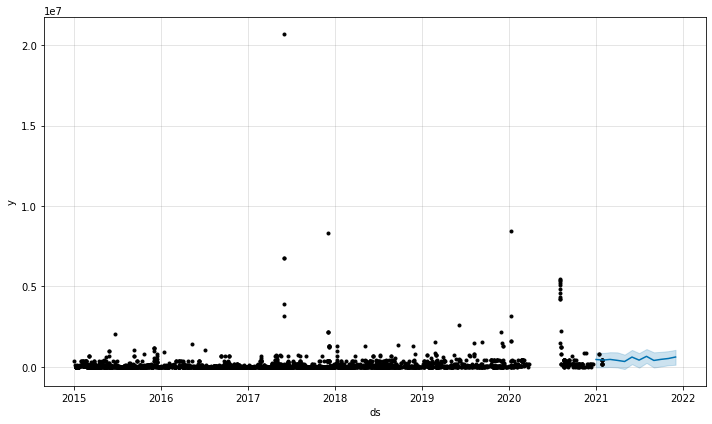

In [64]:
model.plot(forecast)
pyplot.show()

In [65]:
y_true = data_pronostico['y'][-12:].values
y_pred = forecast['yhat'].values

In [66]:
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 381848.738


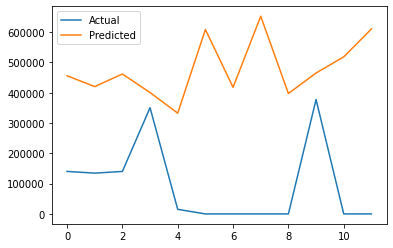

In [67]:
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [68]:
data2= data1[['fecha_de_imposicion', 'monto']]

In [69]:
data2=data2.sort_values('fecha_de_imposicion')

In [70]:
data2=  data2.groupby(['fecha_de_imposicion'], as_index=True).sum()

In [71]:
data2.head()

,monto
fecha_de_imposicion,
2015-01-01,350500.0
2015-01-06,97140.0
2015-01-08,498640.0
2015-01-12,129520.0
2015-01-16,371756.0


In [72]:
y=data2['monto'].resample('MS').mean()

In [73]:
y.head()

fecha_de_imposicion
2015-01-01    291845.333333
2015-02-01    623073.705882
2015-03-01    373754.550000
2015-04-01    308103.800000
2015-05-01    500769.058824
Freq: MS, Name: monto, dtype: float64

<AxesSubplot:xlabel='fecha_de_imposicion'>

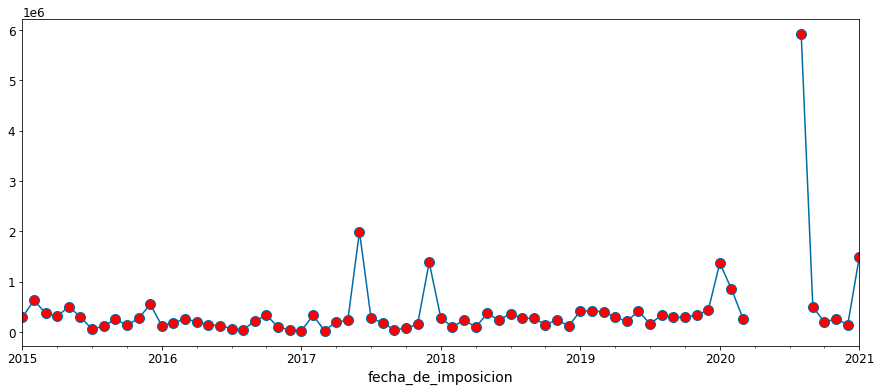

In [74]:
matplotlib.rcParams['axes.labelsize'] =14
matplotlib.rcParams['xtick.labelsize'] =12
matplotlib.rcParams['ytick.labelsize'] =12
fig = plt.figure(facecolor='w')
plt.style.use('tableau-colorblind10')
y.plot(figsize=(15,6),marker="o",markersize=10,markerfacecolor='red')

In [75]:
dftest = adfuller(data2.monto,autolag=None)

In [76]:
print(f'Prueba estadistica {dftest[0]}')
print(f'P-value  {dftest[1]}')
for k, v in dftest[4].items():
    print('\t{}:{} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < dftest[0] else "", 100-int(k[:-1])))


Prueba estadistica -6.313255785520397
P-value  3.196078244272875e-08
	1%:-3.4362549432361504 Los datos son  estacionarios con 99% de confianza
	5%:-2.8641473395601595 Los datos son  estacionarios con 95% de confianza
	10%:-2.568158225793361 Los datos son  estacionarios con 90% de confianza


In [77]:
p = d = q =range(0,2)

In [78]:
pdq=list(itertools.product(p,d,q))

In [79]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
print('Ejemplos de combinaciones de parametros para ARIMA')
print(f'SARIMAX:{pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX:{pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX:{pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX:{pdq[2]} x {seasonal_pdq[4]}')

Ejemplos de combinaciones de parametros para ARIMA
SARIMAX:(0, 0, 1) x (0, 0, 1, 12)
SARIMAX:(0, 0, 1) x (0, 1, 0, 12)
SARIMAX:(0, 1, 0) x (0, 1, 1, 12)
SARIMAX:(0, 1, 0) x (1, 0, 0, 12)


In [80]:
import statsmodels.api as sm
#AIC (Akaike Information Criteria)
# Es un estimador de la calidad de los modelos estadisticos. 
#Nos va a decir que parámetros de SARIMA son mejores para nuestros dataset.
#AIC, el cual, entre más pequeño sea, mejor parámetro para ARIMA.

for param in pdq:
    for param_estacionales  in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_estacionales,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMA {param} x {param_estacionales}12 - AIC:{results.aic}')
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:2053.6331109225152
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:1704.609481443708
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:1697.0102160316355
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:1342.288024925028
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:1724.8358178136602
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:1698.0751521914492
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:1369.971050256658
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:1344.340463099588
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:2019.1880143944245
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:1668.5953484062716
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:1666.8971076159567
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 - AIC:1313.575457493551
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 - AIC:1725.3959868591267
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 - AIC:1664.6939861299754
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 - AIC:1371.707795795277
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 - AIC:1315.1137815396517
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 - AIC:2026.4085495065322
ARI

In [81]:
mod = sm.tsa.statespace.SARIMAX(y,
                                            order=(1,1,1),
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
results = mod.fit()

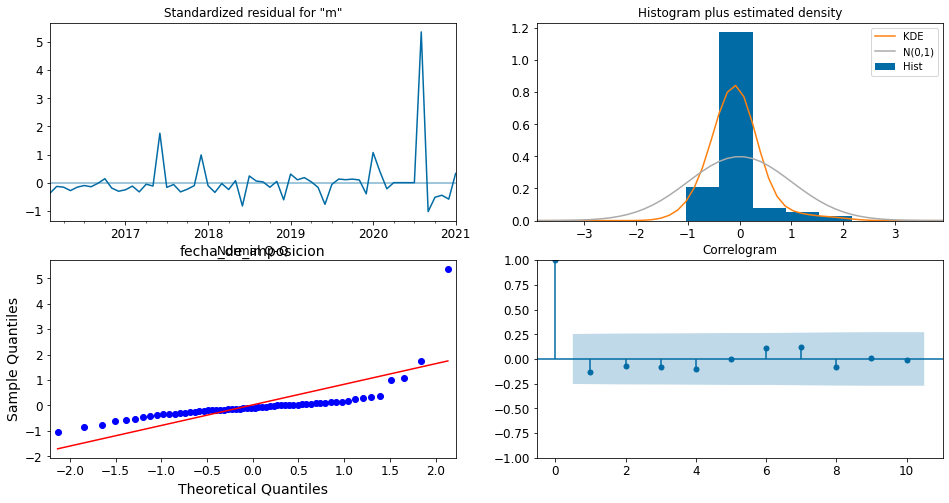

In [82]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [83]:
predicciones = results.get_prediction(start=pd.to_datetime('2019-01-01'))
pred_ci = predicciones.conf_int()

In [84]:
pred_ci

,lower monto,upper monto
fecha_de_imposicion,,
2019-01-01,-1.857942e+06,2.073121e+06
2019-02-01,-1.652479e+06,2.278371e+06
2019-03-01,-1.747528e+06,2.183136e+06
2019-04-01,-1.704761e+06,2.225740e+06
2019-05-01,-1.588246e+06,2.342111e+06
2019-06-01,-7.778333e+05,3.152397e+06
2019-07-01,-1.743740e+06,2.186379e+06
2019-08-01,-1.758930e+06,2.171092e+06
2019-09-01,-1.781255e+06,2.148682e+06


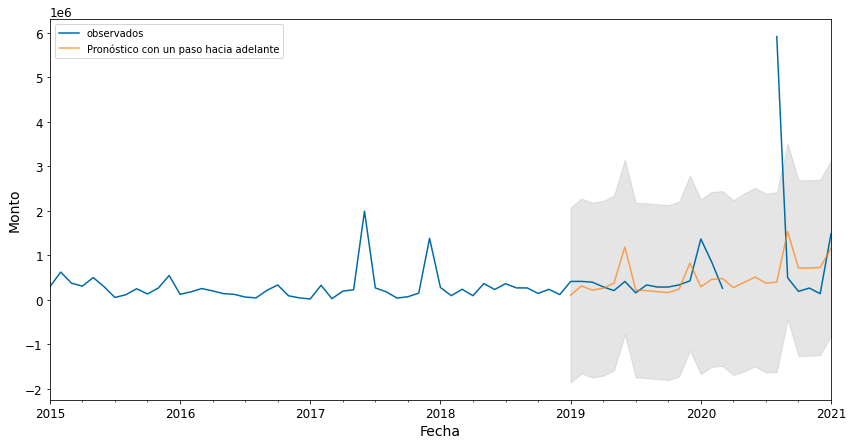

In [85]:
#Graficar nuestra predicción
ax = y['2015':].plot(label='observados')
predicciones.predicted_mean.plot(ax=ax, label='Pronóstico con un paso hacia adelante', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='gray',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto')
plt.legend()
plt.show()

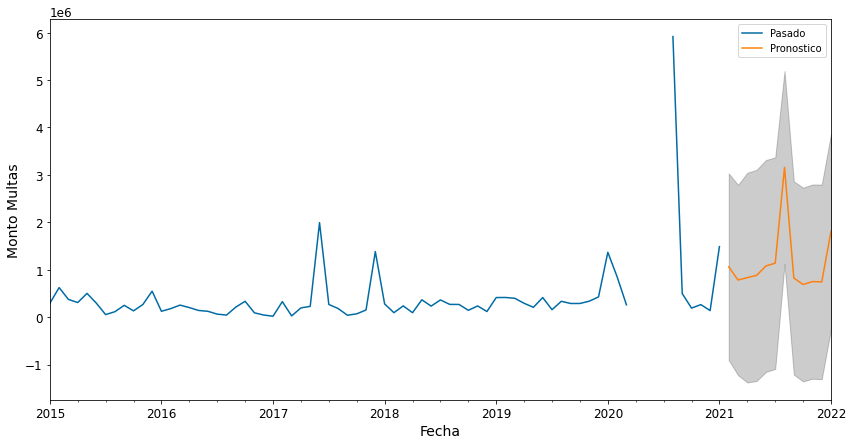

In [86]:
prediccion_futuro = results.get_forecast(steps=12)
pred_ci = prediccion_futuro.conf_int()
ax = y.plot(label='Pasado', figsize=(14,7))
prediccion_futuro.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto Multas')
plt.legend()
plt.show()

###Rolling Monto multa promedio

In [87]:
data1=data[(data['anio_imposicion']>2014) &(data['lavado']=='Si')]

In [88]:
#data1=remove_outlier(data1, 'monto')

In [89]:
data3= data1[['fecha_de_imposicion', 'monto']]

In [90]:
data3 = data3.sort_values('fecha_de_imposicion')

In [91]:
data3 =data3.set_index('fecha_de_imposicion')

In [92]:
#data3=data3.rolling(100).mean()

In [93]:
data3.head()

,monto
fecha_de_imposicion,
2015-01-01,350500.0
2015-01-06,97140.0
2015-01-08,12466.0
2015-01-08,12466.0
2015-01-08,12466.0


In [94]:
data3=data3.dropna()

In [95]:
data3.tail(20)

,monto
fecha_de_imposicion,
2020-11-28,0.0
2020-11-30,168980.0
2020-12-05,168980.0
2020-12-08,168980.0
2020-12-09,168980.0
2020-12-11,0.0
2020-12-15,161200.0
2020-12-19,161200.0
2021-01-13,806000.0


In [96]:
#data3=data3.groupby(['fecha_de_imposicion'], as_index=True).sum()


In [97]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8244 entries, 2015-01-01 to 2021-01-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   monto   8244 non-null   float64
dtypes: float64(1)
memory usage: 128.8 KB


In [98]:

y=data3['monto'].resample('MS').mean()

In [99]:
y.tail()

fecha_de_imposicion
2020-09-01    217746.250000
2020-10-01    130800.000000
2020-11-01    181737.125000
2020-12-01    138223.333333
2021-01-01    371795.833333
Freq: MS, Name: monto, dtype: float64

In [100]:

y=y.rolling(12, win_type='triang').mean()
y=y.dropna()

In [101]:
y

fecha_de_imposicion
2015-12-01     57142.408311
2016-01-01     55139.126197
2016-02-01     56469.914404
2016-03-01     61367.292372
2016-04-01     68184.012730
2016-05-01     75957.427037
2016-06-01     79556.669106
2016-07-01     77759.431986
2016-08-01     72728.414206
2016-09-01     64137.349456
2016-10-01     53851.700795
2016-11-01     43153.142237
2016-12-01     34790.896297
2017-01-01     29188.893112
2017-02-01     25271.603008
2017-03-01     22836.564601
2017-04-01     19837.324119
2017-05-01     16605.640092
2017-06-01     15110.655036
2017-07-01     15948.786235
2017-08-01     18201.427056
2017-09-01     21431.721780
2017-10-01     26381.332653
2017-11-01     32458.764550
2017-12-01     38689.051094
2018-01-01     44277.353054
2018-02-01     48378.258987
2018-03-01     52540.398593
2018-04-01     57703.748056
2018-05-01     64432.296759
2018-06-01     70665.831909
2018-07-01     74090.227064
2018-08-01     78137.022694
2018-09-01     82637.909705
2018-10-01     85835.263378


<AxesSubplot:xlabel='fecha_de_imposicion'>

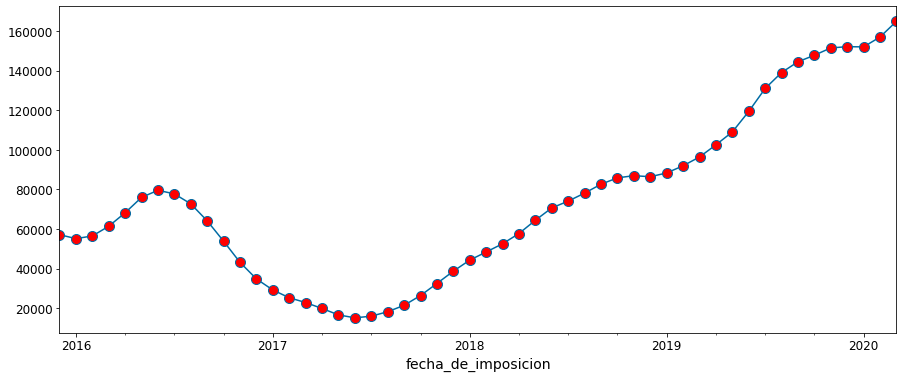

In [102]:
matplotlib.rcParams['axes.labelsize'] =14
matplotlib.rcParams['xtick.labelsize'] =12
matplotlib.rcParams['ytick.labelsize'] =12
fig = plt.figure(facecolor='w')
plt.style.use('tableau-colorblind10')
y.plot(figsize=(15,6),marker="o",markersize=10,markerfacecolor='red')

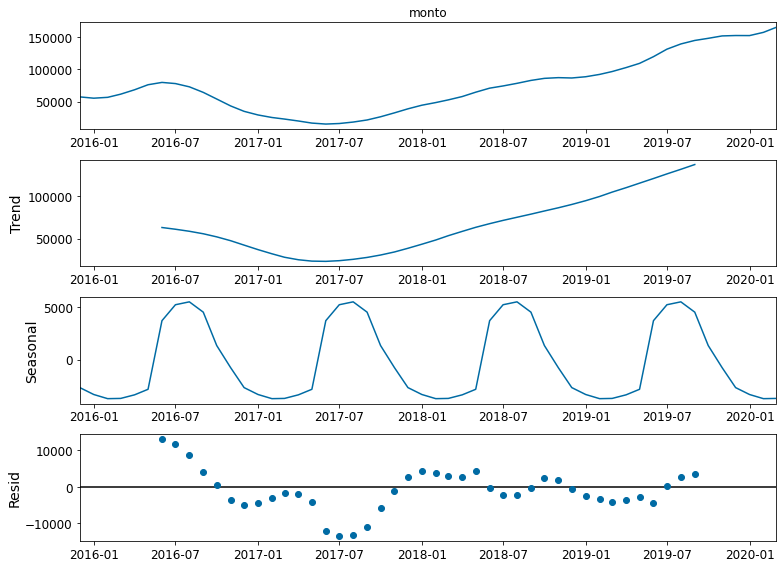

In [103]:
matplotlib.rcParams['figure.figsize'] =11,8
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig =decomposition.plot()
plt.show()

In [104]:
dftest = adfuller(data3.monto,autolag=None)

In [105]:
print(f'Prueba estadistica {dftest[0]}')
print(f'P-value  {dftest[1]}')
for k, v in dftest[4].items():
    print('\t{}:{} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < dftest[0] else "", 100-int(k[:-1])))


Prueba estadistica -11.869298702411294
P-value  6.561187426753701e-22
	1%:-3.431147141939558 Los datos son  estacionarios con 99% de confianza
	5%:-2.8618922808382328 Los datos son  estacionarios con 95% de confianza
	10%:-2.566957514295699 Los datos son  estacionarios con 90% de confianza


In [106]:
import statsmodels.api as sm
#AIC (Akaike Information Criteria)
# Es un estimador de la calidad de los modelos estadisticos. 
#Nos va a decir que parámetros de SARIMA son mejores para nuestros dataset.
#AIC, el cual, entre más pequeño sea, mejor parámetro para ARIMA.

for param in pdq:
    for param_estacionales  in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_estacionales,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMA {param} x {param_estacionales}12 - AIC:{results.aic}')
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:1305.8063071636216
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:49588.6585880688
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:958.8615274833461
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:2365.253845286646
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:977.1161640116101
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:907.7277878103378
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:689.7748263566249


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:696.1650498239842
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:1248.019247235616
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:39804.11374389866
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:910.1805035325291


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (0, 1, 1, 12)12 - AIC:2195.400112584009
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 - AIC:994.0140028225751
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 - AIC:944.8775791305044
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 - AIC:672.4122339679241


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (1, 1, 1, 12)12 - AIC:2108.7206891703695
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 - AIC:1005.7833550265605
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 - AIC:763.0693780086057
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 - AIC:784.3288005196036
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 - AIC:1027.3731208436748
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 - AIC:779.6997158962839
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 - AIC:973.158191874594
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 - AIC:534.2953690789489


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 - AIC:1042.749685612506
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 - AIC:945.4697313384958
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 - AIC:714.981447914096
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 - AIC:739.3685204409315


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 - AIC:2033.8792673233097
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 - AIC:734.1137023549475
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 - AIC:785.1420485065055
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 - AIC:532.0208600523522


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 - AIC:2138.1528234965263
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 - AIC:1013.5677885404172
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 - AIC:756.756253637503
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 - AIC:805.7689371668242


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (0, 1, 1, 12)12 - AIC:836.1264755603339
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 - AIC:756.9656690095351
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 - AIC:758.9152649865962
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 - AIC:542.5919657680475


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (1, 1, 1, 12)12 - AIC:1139.4131902818087
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 - AIC:937.3156672659836
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 - AIC:775.6937163829982
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:790.0283801948749


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:2167.8805598795066
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:709.2710031004716
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:712.8822258740746
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:532.9104854918247
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:2078.4081509174594
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:917.0998688679842
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:687.0219724434577
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:721.8197269609161


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:843.0884322939077
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:688.7541320756609
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:688.2864217952911
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:478.51164227449965
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:1136.9180102565128
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:880.1242342776429
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:656.1357398634617
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 - AIC:695.2061603591086


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 - AIC:823.1780281889106
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 - AIC:675.0199894678083


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 1) x (1, 0, 1, 12)12 - AIC:659.4534046450511
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 - AIC:479.8315359504473
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 - AIC:957.878865177082


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [107]:
mod = sm.tsa.statespace.SARIMAX(y,
                                            order=(1,1,0),
                                            seasonal_order=(1, 1, 0, 12),
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
results = mod.fit()

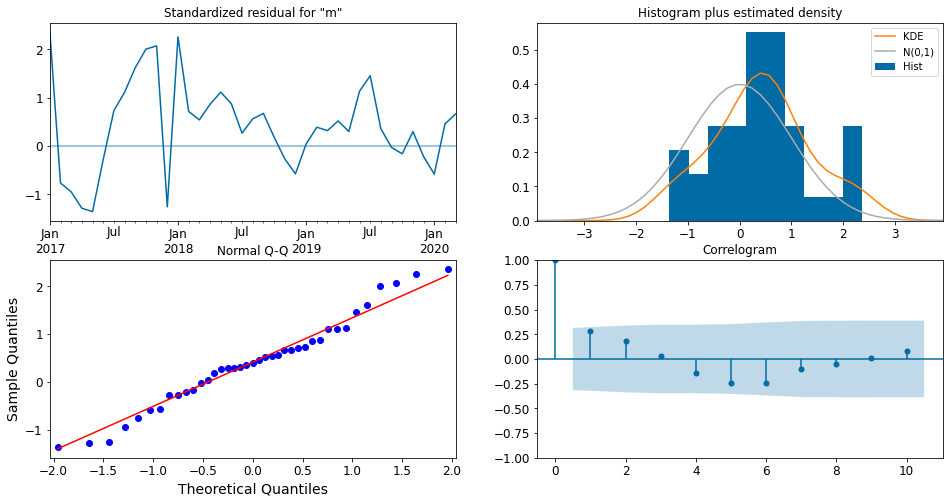

In [108]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [109]:
predicciones = results.get_prediction(start=pd.to_datetime('2019-01-01'))
pred_ci = predicciones.conf_int()

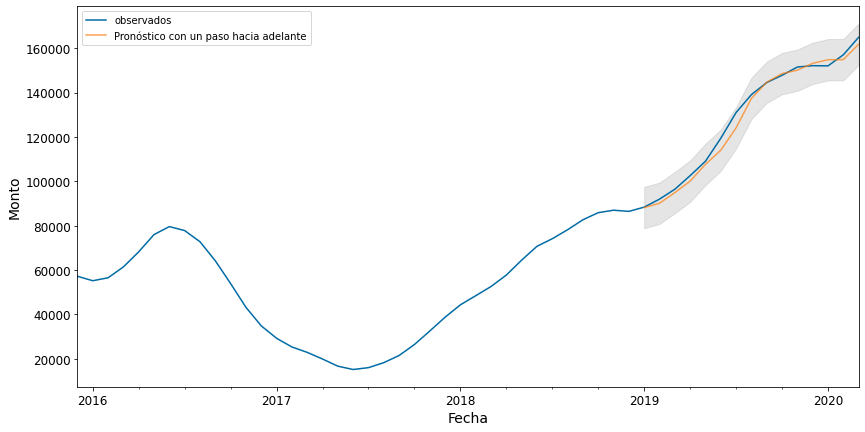

In [110]:
#Graficar nuestra predicción
ax = y['2015':].plot(label='observados')
predicciones.predicted_mean.plot(ax=ax, label='Pronóstico con un paso hacia adelante', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='gray',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto')
plt.legend()
plt.show()

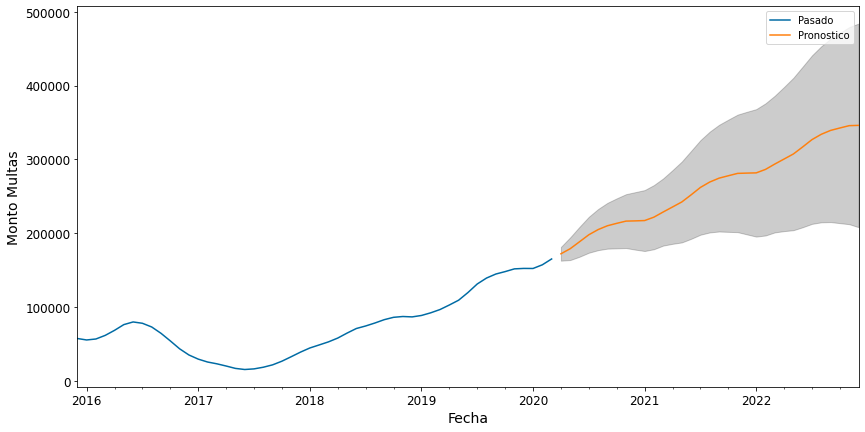

In [111]:
prediccion_futuro = results.get_forecast(steps=33)
pred_ci = prediccion_futuro.conf_int()
ax = y.plot(label='Pasado', figsize=(14,7))
prediccion_futuro.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto Multas')
plt.legend()
plt.show()


data3= data1[['fecha_de_imposicion', 'monto']]
data3=data3.groupby(['fecha_de_imposicion'], as_index=True).mean()
data3 = data3.sort_values('fecha_de_imposicion')
#data3=remove_outlier(data3, 'monto')
#data3 =data3.set_index('fecha_de_imposicion')


y=data3['monto'].resample('MS').mean()

In [112]:
grafica_montop_lavado= pd.DataFrame(data=y)
grafica_montop_lavado=grafica_montop_lavado.reset_index()

#grafica_montop_lavado=remove_outlier(grafica_montop_lavado, 'monto')

In [113]:
pred_ci['monto_mean'] = pred_ci.mean(axis=1)
pred_grafica_montop_lavado=pred_ci.reset_index()


In [114]:

pred_grafica_montop_lavado = pred_grafica_montop_lavado.rename(columns={'index': 'fecha'})


In [115]:

#pred_grafica_montop_lavado= pred_grafica_montop_lavado.tail(24)

In [116]:
#fig = go.Figure()
trace0=go.Scatter(x= grafica_montop_lavado.fecha_de_imposicion, y=grafica_montop_lavado.monto,
                        mode='lines+markers',
                    name='Actual')

trace1= go.Scatter(x= pred_grafica_montop_lavado.fecha, y=pred_grafica_montop_lavado.monto_mean,
                    mode='markers', name='Forecast', marker_symbol= 2)
layout=go.Layout(title='Average Amount of Anty Money Laundering Fines',
                   xaxis_title='Year',
                   yaxis_title='Amount')

datos = [trace0, trace1]
fig= dict(data=datos, layout=layout)
py.plot(fig, filename = 'A_AML', auto_open=True)



'https://plotly.com/~VictorHdz/14/'

Rolling Monto multa promedio no lavado

In [117]:
data1=data[(data['anio_imposicion']>2014)&(data['lavado']=='No')]



In [118]:
#data1=remove_outlier(data1, 'monto')

In [119]:
data3= data1[['fecha_de_imposicion', 'monto']]
data3 = data3.sort_values('fecha_de_imposicion')
data3 =data3.set_index('fecha_de_imposicion')
data3=data3.dropna()
y=data3['monto'].resample('MS').mean()
y=y.rolling(12,win_type='triang').mean()
y=y.dropna()


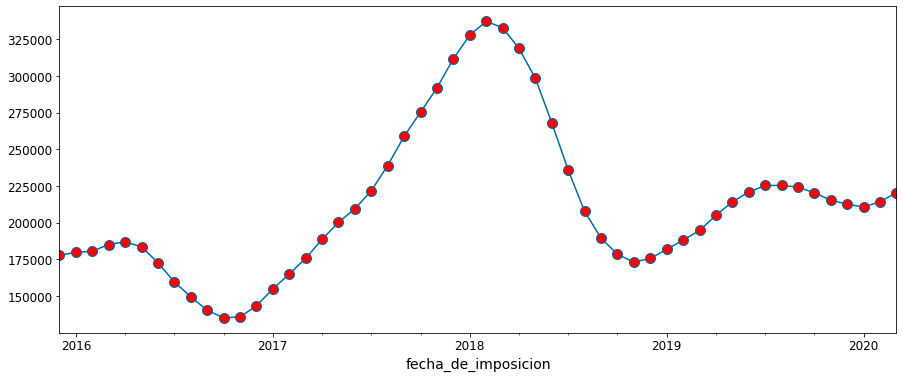

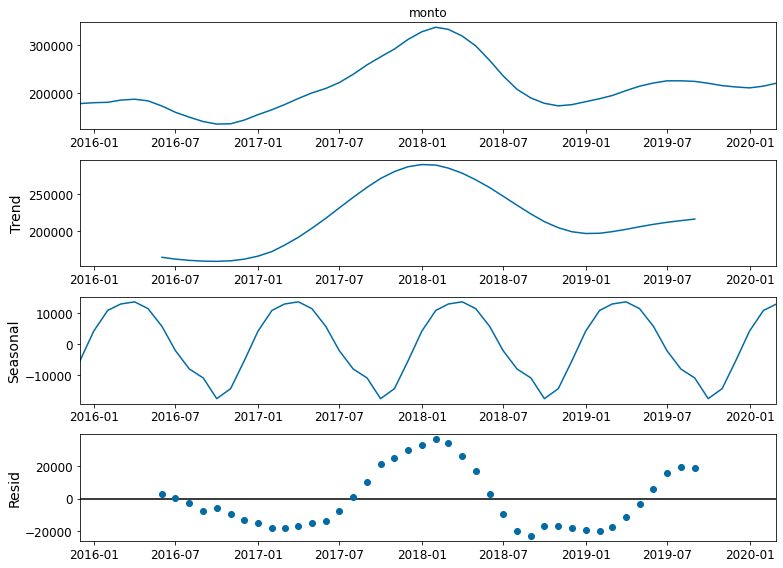

In [120]:
matplotlib.rcParams['axes.labelsize'] =14
matplotlib.rcParams['xtick.labelsize'] =12
matplotlib.rcParams['ytick.labelsize'] =12
fig = plt.figure(facecolor='w')
plt.style.use('tableau-colorblind10')
y.plot(figsize=(15,6),marker="o",markersize=10,markerfacecolor='red')


matplotlib.rcParams['figure.figsize'] =11,8
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig =decomposition.plot()
plt.show()

In [121]:
dftest = adfuller(data3.monto,autolag=None)
for param in pdq:
    for param_estacionales  in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_estacionales,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMA {param} x {param_estacionales}12 - AIC:{results.aic}')
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:1401.1050187572848
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:1055.5701567692183
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:1008.8746746913675


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:1083.2734903537048
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:1033.807586465207
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:1023.2433440872118
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:712.1888254656222


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:1020.6802711644315
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:1340.7087910698253
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:1075.3989318708434
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:1004.9581248532305
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 - AIC:2147.4931782810822
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 - AIC:1143.524360780484
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 - AIC:1075.4474055080652
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 - AIC:706.4901808993952


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 0, 1) x (1, 1, 1, 12)12 - AIC:2088.1208924547313
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 - AIC:1087.2086370328655
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 - AIC:830.8286169015131
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 - AIC:873.4215681548585


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 1, 0) x (0, 1, 1, 12)12 - AIC:1059.6911235173816
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 - AIC:850.7766435793303
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 - AIC:828.1229451163883
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 - AIC:592.7640726920641


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 1, 0) x (1, 1, 1, 12)12 - AIC:1228.7171231429559
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 - AIC:1028.7604822491764
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 - AIC:780.5461012078086
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 - AIC:831.9156520158247


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 1, 1) x (0, 1, 1, 12)12 - AIC:1877.0831555489553
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 - AIC:822.8485354612175
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 - AIC:782.4306254355569
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 - AIC:590.9627462054661


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 1, 1) x (1, 1, 1, 12)12 - AIC:2002.738894557591
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 - AIC:1109.8300273899072
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 - AIC:853.9058292758986
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 - AIC:896.8059288957946


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 0) x (0, 1, 1, 12)12 - AIC:859.4277187128779
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 - AIC:852.2260656632996
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 - AIC:854.0488284251192
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 - AIC:605.4854882018168


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 0) x (1, 1, 1, 12)12 - AIC:626.0932980281857
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 - AIC:1041.9396448862826
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 - AIC:796.2867913172352
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:887.9892338729574


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:2222.258473611083
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:818.3011730543238
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:798.2706578982107
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:617.363857222889


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:2156.715732814472
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:992.2935505260137
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:758.9672199472891
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:785.3749192607958


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:899.5800350993281
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:758.9637332132186
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:760.2343018029047
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:533.1270767201136
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:1110.0206037789571
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:956.2712234411551
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:718.0349689937267
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 - AIC:755.4557593067848
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 - AIC:1025.039658903579
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 - AIC:735.4048486149161
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 - AIC:718.7076922868509
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 - AIC:533.9436818048729
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 - AIC:1026.8421177418427


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [122]:
print(f'Prueba estadistica {dftest[0]}')
print(f'P-value  {dftest[1]}')
for k, v in dftest[4].items():
    print('\t{}:{} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < dftest[0] else "", 100-int(k[:-1])))


Prueba estadistica -10.926419774249307
P-value  1.007531790274151e-19
	1%:-3.431459026589205 Los datos son  estacionarios con 99% de confianza
	5%:-2.8620300862687587 Los datos son  estacionarios con 95% de confianza
	10%:-2.5670308706869647 Los datos son  estacionarios con 90% de confianza


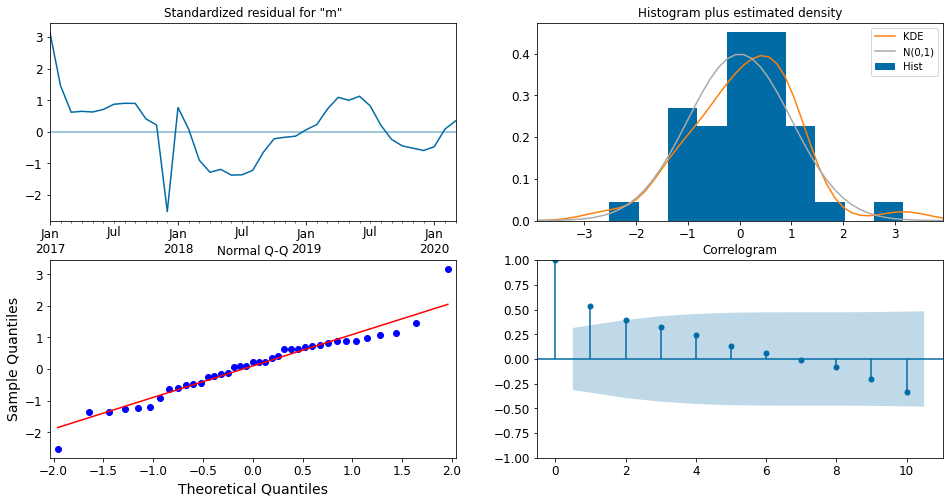

In [123]:
mod = sm.tsa.statespace.SARIMAX(y,
                                            order=(1,1,1),
                                            seasonal_order=(1, 1, 0, 12),
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [124]:
predicciones = results.get_prediction(start=pd.to_datetime('2019-01-01'))
pred_ci = predicciones.conf_int()

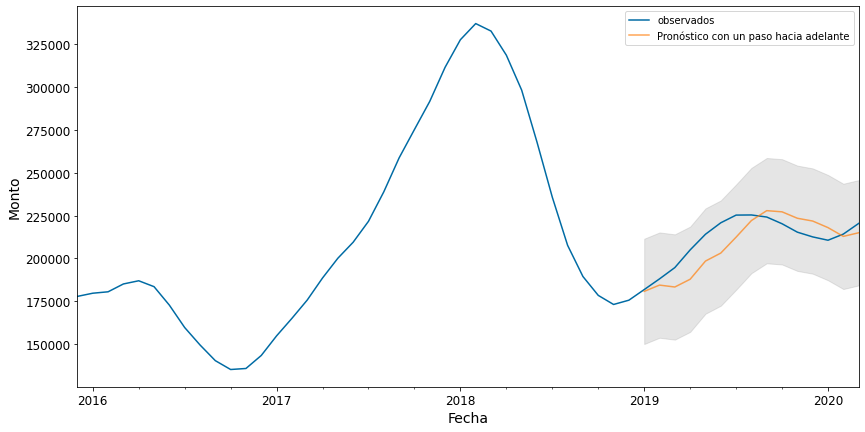

In [125]:
ax = y['2015':].plot(label='observados')
predicciones.predicted_mean.plot(ax=ax, label='Pronóstico con un paso hacia adelante', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='gray',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto')
plt.legend()
plt.show()

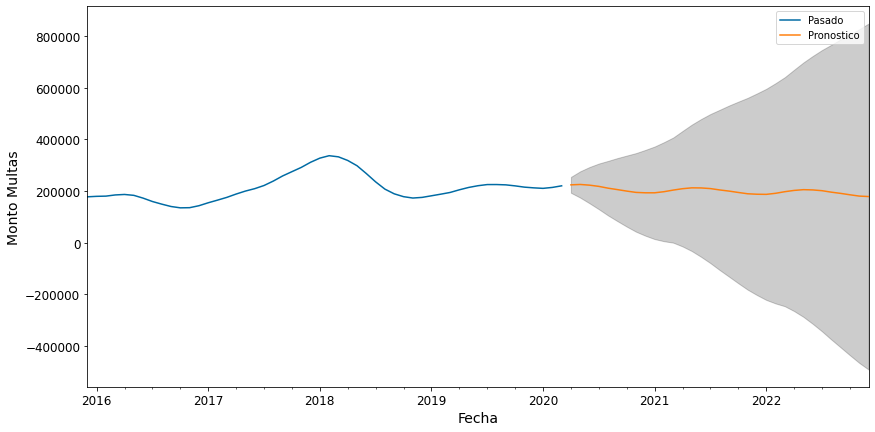

In [126]:
prediccion_futuro = results.get_forecast(steps=33)
pred_ci = prediccion_futuro.conf_int()
ax = y.plot(label='Pasado', figsize=(14,7))
prediccion_futuro.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto Multas')
plt.legend()
plt.show()

data1=data[(data['anio_imposicion']>2014)&(data['lavado']=='No')]

data3= data1[['fecha_de_imposicion', 'monto']]
data3=remove_outlier(data3, 'monto')
data3=data3.groupby(['fecha_de_imposicion'], as_index=True).mean()
data3 = data3.sort_values('fecha_de_imposicion')

#data3 =data3.set_index('fecha_de_imposicion')
y=data3['monto'].resample('MS').mean()

grafica_montop_nlavado= pd.DataFrame(data=y)
grafica_montop_nlavado=grafica_montop_nlavado.reset_index()

grafica_montop_nlavado=remove_outlier(grafica_montop_nlavado, 'monto')


pred_ci['monto_mean'] = pred_ci.mean(axis=1)
pred_grafica_montop_nlavado=pred_ci.reset_index()
pred_grafica_montop_nlavado = pred_grafica_montop_nlavado.rename(columns={'index': 'fecha'})
#pred_grafica_montop_nlavado= pred_grafica_montop_nlavado.tail(24)

In [127]:
grafica_montop_nlavado= pd.DataFrame(data=y)
grafica_montop_nlavado=grafica_montop_nlavado.reset_index()

grafica_montop_nlavado=remove_outlier(grafica_montop_nlavado, 'monto')
pred_ci['monto_mean'] = pred_ci.mean(axis=1)
pred_grafica_montop_nlavado=pred_ci.reset_index()
pred_grafica_montop_nlavado = pred_grafica_montop_nlavado.rename(columns={'index': 'fecha'})
#pred_grafica_montop_nlavado= pred_grafica_montop_nlavado.tail(24)

In [128]:
#fig = go.Figure()
trace0 = go.Scatter(x = grafica_montop_nlavado.fecha_de_imposicion, y=grafica_montop_nlavado.monto, mode='lines+markers',
                    name='Actual')

trace1= go.Scatter(x = pred_grafica_montop_nlavado.fecha, y=pred_grafica_montop_nlavado.monto_mean,mode='markers',
                    name='Forecast', marker_symbol= 2, line=dict(color='rgb(231, 63, 116)') )

layout =go.Layout(title='Average Amount of Non-Anti Money Laundering Fines', 
                   xaxis_title='Year',
                   yaxis_title='Amount')

datos = [trace0, trace1]
fig= dict(data=datos, layout=layout)
py.plot(fig, filename = 'A_NAML', auto_open=True)


'https://plotly.com/~VictorHdz/10/'

In [129]:
y

fecha_de_imposicion
2015-12-01    177886.040544
2016-01-01    179732.903627
2016-02-01    180561.725962
2016-03-01    185135.616590
2016-04-01    186998.752773
2016-05-01    183560.697834
2016-06-01    172776.555360
2016-07-01    159706.566819
2016-08-01    149545.345544
2016-09-01    140373.078613
2016-10-01    135202.404016
2016-11-01    135799.204371
2016-12-01    143391.426493
2017-01-01    154835.591486
2017-02-01    165046.041335
2017-03-01    175733.896600
2017-04-01    188615.838830
2017-05-01    200147.380906
2017-06-01    209500.049516
2017-07-01    221708.357406
2017-08-01    238922.942605
2017-09-01    258731.174005
2017-10-01    275282.493218
2017-11-01    291718.069275
2017-12-01    311588.767453
2018-01-01    327701.332223
2018-02-01    337125.241554
2018-03-01    332744.754481
2018-04-01    318682.508566
2018-05-01    298283.171396
2018-06-01    267974.366477
2018-07-01    235792.141152
2018-08-01    207671.776944
2018-09-01    189489.183205
2018-10-01    178470.697683


Rolling Acumulado lavado

In [130]:
data1=data[(data['anio_imposicion']>2014)&(data['lavado']=='Si')]


In [131]:
data3= data1[['fecha_de_imposicion', 'monto']]
data3 = data3.sort_values('fecha_de_imposicion')
data3 =data3.set_index('fecha_de_imposicion')
data3=data3.dropna()
y=data3['monto'].resample('MS').sum()
y=y.rolling(12,win_type='triang').sum()
y=y.dropna()


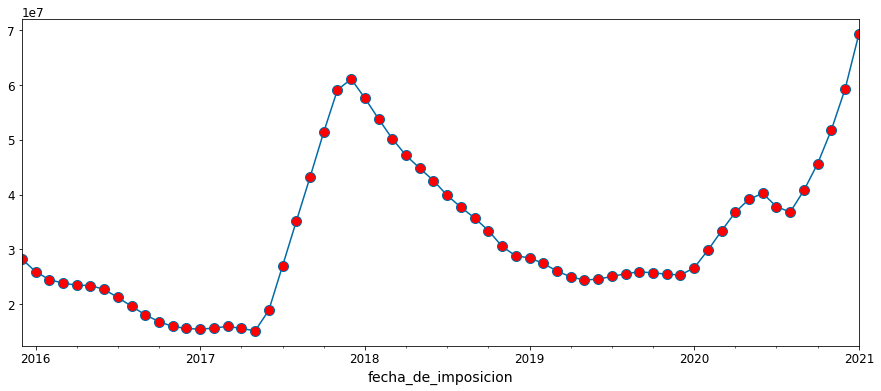

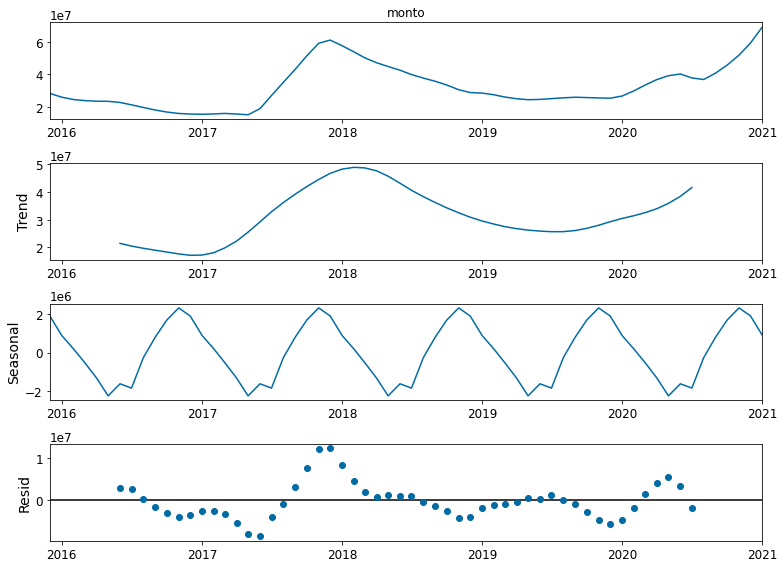

In [132]:
matplotlib.rcParams['axes.labelsize'] =14
matplotlib.rcParams['xtick.labelsize'] =12
matplotlib.rcParams['ytick.labelsize'] =12
fig = plt.figure(facecolor='w')
plt.style.use('tableau-colorblind10')
y.plot(figsize=(15,6),marker="o",markersize=10,markerfacecolor='red')


matplotlib.rcParams['figure.figsize'] =11,8
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig =decomposition.plot()
plt.show()

In [133]:
dftest = adfuller(data3.monto,autolag=None)
for param in pdq:
    for param_estacionales  in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_estacionales,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMA {param} x {param_estacionales}12 - AIC:{results.aic}')
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:2294.8326853049807
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:1833.885644355755
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:1801.3817949553572
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:1348.1916219065934
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:1837.5462350002592
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:1790.278659282141
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:1383.486078276475
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:1345.1709517624633
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:2217.8027060240693
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:1773.113463960848
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:1733.8980918592001
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 - AIC:1350.0276680166376
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 - AIC:1843.2474691791651
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 - AIC:1770.9686778896933
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 - AIC:1430.5559755973957
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 - AIC:1351.9193480391632
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 - AIC:1980.2265407720292
A

/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 1) x (0, 0, 1, 12)12 - AIC:1570.43924198697
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:1604.4806131708579
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:1235.1255382410013
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:1575.5096498841017


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:1594.3343269513616
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:1228.4308251411182
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:1237.0375322121388
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:1892.9160172715392
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:1527.4294290369828
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:1556.688543133796
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:1156.3982666847933
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:1526.3352586462233
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:1528.330416776154
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:1152.5488596999674
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:1154.5431534912923
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:1847.1217679687868
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:1473.6517929261738
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 - AIC:1514.6461970257133
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 - AIC:1115.4174675286981
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 - AIC:1502.8934058542345
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 - AIC:1474.3782185506875

In [134]:
print(f'Prueba estadistica {dftest[0]}')
print(f'P-value  {dftest[1]}')
for k, v in dftest[4].items():
    print('\t{}:{} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < dftest[0] else "", 100-int(k[:-1])))



Prueba estadistica -11.869298702411294
P-value  6.561187426753701e-22
	1%:-3.431147141939558 Los datos son  estacionarios con 99% de confianza
	5%:-2.8618922808382328 Los datos son  estacionarios con 95% de confianza
	10%:-2.566957514295699 Los datos son  estacionarios con 90% de confianza


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



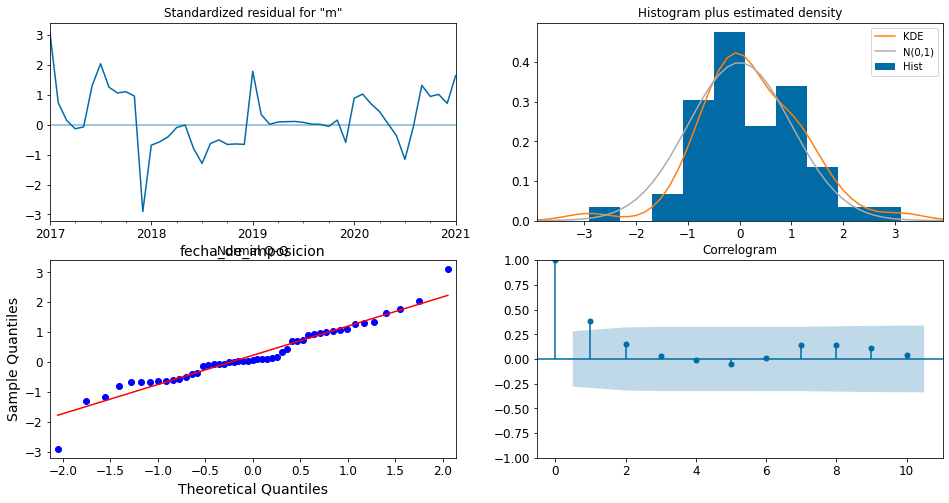

In [135]:
mod = sm.tsa.statespace.SARIMAX(y,
                                            order=(1,1,1),
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [136]:
predicciones = results.get_prediction(start=pd.to_datetime('2019-01-01'))
pred_ci = predicciones.conf_int()

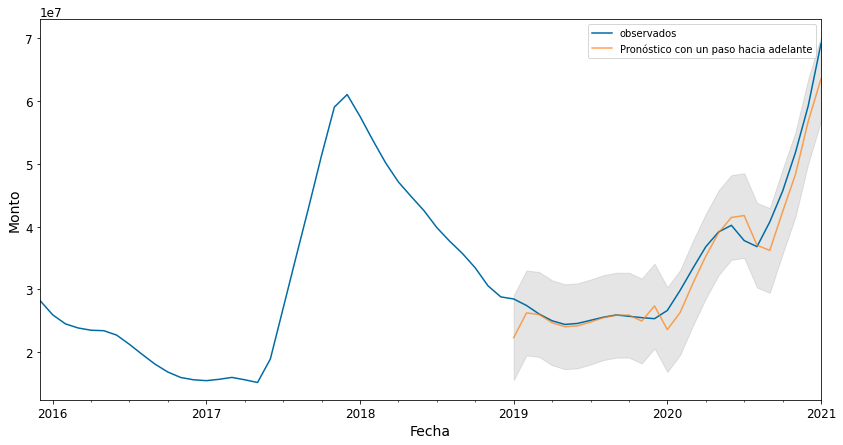

In [137]:
ax = y['2015':].plot(label='observados')
predicciones.predicted_mean.plot(ax=ax, label='Pronóstico con un paso hacia adelante', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='gray',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto')
plt.legend()
plt.show()

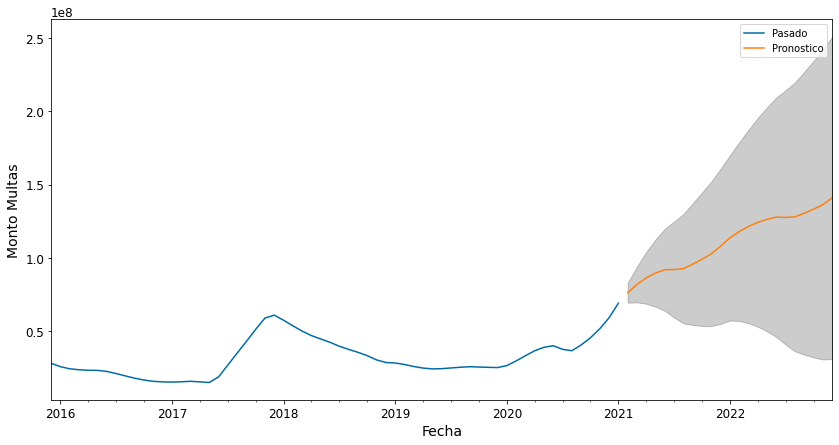

In [138]:
prediccion_futuro = results.get_forecast(steps=23)
pred_ci = prediccion_futuro.conf_int()
ax = y.plot(label='Pasado', figsize=(14,7))
prediccion_futuro.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto Multas')
plt.legend()
plt.show()

In [139]:
data1=data[(data['anio_imposicion']>2014)&(data['lavado']=='Si')]

In [140]:
data3= data1[['fecha_de_imposicion', 'monto']]
data3 = data3.sort_values('fecha_de_imposicion')
data3 =data3.set_index('fecha_de_imposicion')
data3['monto'] = data3['monto'].astype('int64')
#data3=data3.dropna()
y=data3['monto'].resample('A').sum()

In [141]:
y=y.head(6)

In [142]:
grafica_montoa_lavado= pd.DataFrame(data=y)
grafica_montoa_lavado=grafica_montoa_lavado.reset_index()
grafica_montoa_lavado['fecha_de_imposicion'] = grafica_montoa_lavado['fecha_de_imposicion'].dt.strftime('%Y')

In [143]:
grafica_montoa_lavado

,fecha_de_imposicion,monto
0,2015,62897419
1,2016,30666097
2,2017,102331821
3,2018,50404796
4,2019,55678735
5,2020,107885141


In [144]:


#grafica_montoa_lavado=remove_outlier(grafica_montoa_lavado, 'monto')
pred_ci['monto_mean'] = pred_ci.mean(axis=1)
pred_grafica_montoa_lavado=pred_ci['monto_mean'].resample('A').mean()
pred_grafica_montoa_lavado=pred_grafica_montoa_lavado.reset_index()

pred_grafica_montoa_lavado = pred_grafica_montoa_lavado.rename(columns={'index': 'fecha'})
pred_grafica_montoa_lavado=pred_grafica_montoa_lavado[['fecha','monto_mean']]
pred_grafica_montoa_lavado['monto_mean']=pred_grafica_montoa_lavado['monto_mean'].astype('int64')
pred_grafica_montoa_lavado['fecha'] = pred_grafica_montoa_lavado['fecha'].dt.strftime('%Y')

In [145]:
pred_grafica_montoa_lavado

,fecha,monto_mean
0,2021,92473983
1,2022,127367558


In [146]:
#fig = go.Figure()
trace0 = go.Bar(x = grafica_montoa_lavado.fecha_de_imposicion, y=grafica_montoa_lavado.monto,
                    name='Actual')

trace1= go.Bar(x = pred_grafica_montoa_lavado.fecha, y=pred_grafica_montoa_lavado.monto_mean,
                    name='Forecast',) 

layout =go.Layout(title='Aggregate Amount of Anti Money Laundering Fines', 
                   xaxis_title='Year',
                   yaxis_title='Amount')

datos = [trace0, trace1]
fig= dict(data=datos, layout=layout)
py.plot(fig, filename = 'Ag_AML', auto_open=True)

'https://plotly.com/~VictorHdz/21/'

Rolling acumulado no lavado

In [147]:
data1=data[(data['anio_imposicion']>2014)&(data['monto']>0) &(data['lavado']=='No')]

In [148]:
data1=remove_outlier(data1, 'monto')
data3= data1[['fecha_de_imposicion', 'monto']]

data3 = data3.sort_values('fecha_de_imposicion')
data3 =data3.set_index('fecha_de_imposicion')
data3=data3.dropna()
y=data3['monto'].resample('MS').sum()
y=y.rolling(12,win_type='triang').sum()
y=y.dropna()


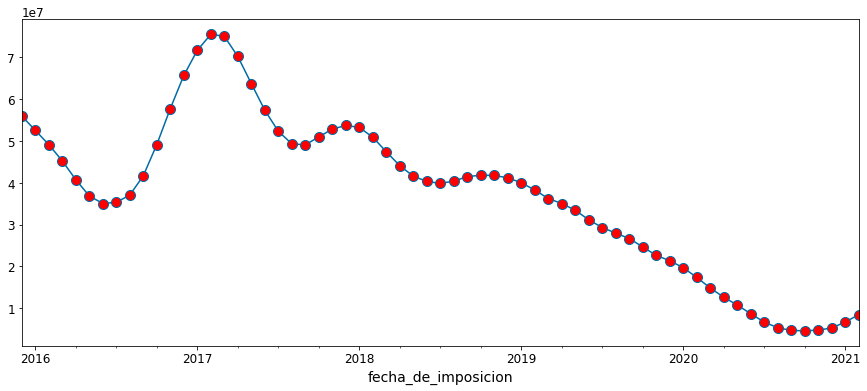

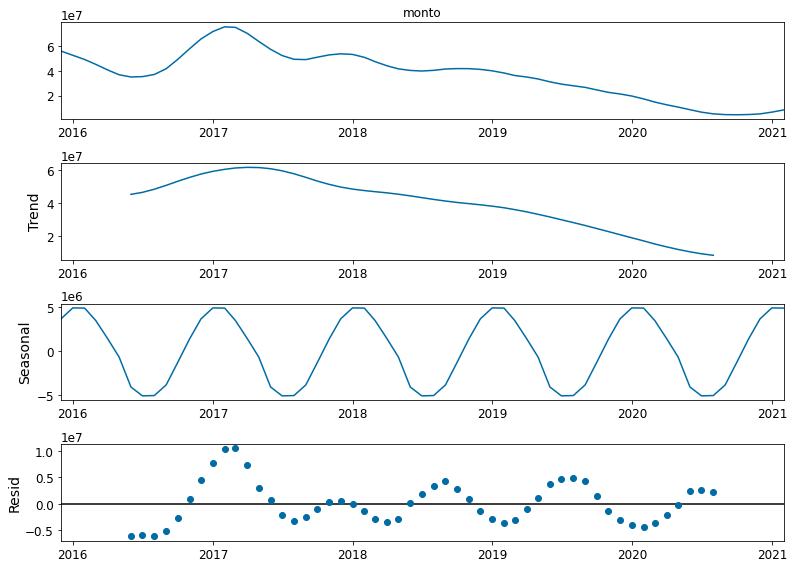

In [149]:
matplotlib.rcParams['axes.labelsize'] =14
matplotlib.rcParams['xtick.labelsize'] =12
matplotlib.rcParams['ytick.labelsize'] =12
fig = plt.figure(facecolor='w')
plt.style.use('tableau-colorblind10')
y.plot(figsize=(15,6),marker="o",markersize=10,markerfacecolor='red')


matplotlib.rcParams['figure.figsize'] =11,8
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig =decomposition.plot()
plt.show()

In [150]:
dftest = adfuller(data3.monto,autolag=None)
for param in pdq:
    for param_estacionales  in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_estacionales,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMA {param} x {param_estacionales}12 - AIC:{results.aic}')
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:2353.1071408399253
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:1828.249193901984
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:1816.2903168930081
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:10778363074.64733
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:1839.365188023024
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:1797.345878976003
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:1413.5977069760115
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:10875072652.77466
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:2272.8023546729223
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:1985.7496950976147
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:1886.7412046541688


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 0, 1) x (0, 1, 1, 12)12 - AIC:10232521321.370243
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 - AIC:2101.902917313601
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 - AIC:1987.3993018803583
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 - AIC:1449.8603820686653


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 0, 1) x (1, 1, 1, 12)12 - AIC:10009785183.631433
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 - AIC:1999.4924150838701
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 - AIC:1585.8110926505947
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 - AIC:1612.866746257727
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 - AIC:480640.605468173
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 - AIC:1614.111662764817
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 - AIC:1600.5855816258872
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 - AIC:1221.7208502246312
ARIMA (0, 1, 0) x (1, 1, 1, 12)12 - AIC:25220.177303949575
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 - AIC:1919.673294235696
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 - AIC:1636.627500164892
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 - AIC:1631.9629764899992
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 - AIC:1149.9922490210504
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 - AIC:1722.5873196744465
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 - AIC:1638.1662732831753
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 - AIC:1216.1779565693448
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 - AIC:1188.8664253829315
ARI

/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 0) x (1, 1, 1, 12)12 - AIC:4984.1664168162115
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 - AIC:1967.2692550772351


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 1) x (0, 0, 1, 12)12 - AIC:1534.8553535198246
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 - AIC:1676.7289716056096


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 1) x (0, 1, 1, 12)12 - AIC:1282713760.3705788
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 - AIC:1616.9846024125595
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 - AIC:1598.7390630242535
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 - AIC:1253.2555458722957


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 1) x (1, 1, 1, 12)12 - AIC:359794513.3540653
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 - AIC:1898.6398908731521
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 - AIC:1514.2581013295787
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 - AIC:1532.770624576838
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 - AIC:1778.0823278484177
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 - AIC:1510.6565539794672
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 - AIC:1512.646539309299
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:1149.6800744580307
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 - AIC:2058.0318822767467
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 - AIC:1852.8092047194475
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 - AIC:1456.1439647944646
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 - AIC:1486.2167523815783
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 - AIC:1715.5244393139556
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 - AIC:1483.0756563465704
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 - AIC:1454.8902364113892
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 - AIC:1130.5649215520045
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 - AIC:3466.4139830545923


/usr/local/Cellar/jupyterlab/2.2.9/libexec/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [151]:
print(f'Prueba estadistica {dftest[0]}')
print(f'P-value  {dftest[1]}')
for k, v in dftest[4].items():
    print('\t{}:{} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < dftest[0] else "", 100-int(k[:-1])))



Prueba estadistica -10.120083374420764
P-value  9.495643433118396e-18
	1%:-3.431956142626598 Los datos son  estacionarios con 99% de confianza
	5%:-2.862249705862999 Los datos son  estacionarios con 95% de confianza
	10%:-2.5671477833810394 Los datos son  estacionarios con 90% de confianza


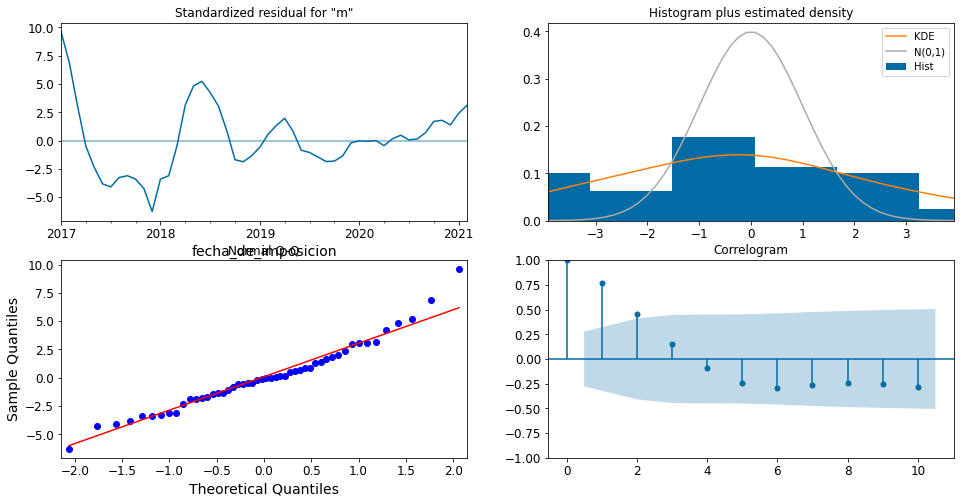

In [152]:
mod = sm.tsa.statespace.SARIMAX(y,
                                            order=(1,1,1),
                                            seasonal_order=(1, 1, 0, 12),
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [153]:
predicciones = results.get_prediction(start=pd.to_datetime('2019-01-01'))
pred_ci = predicciones.conf_int()

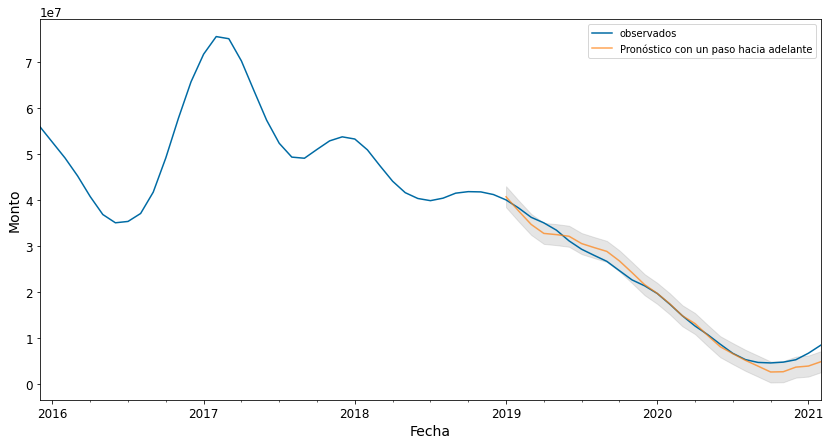

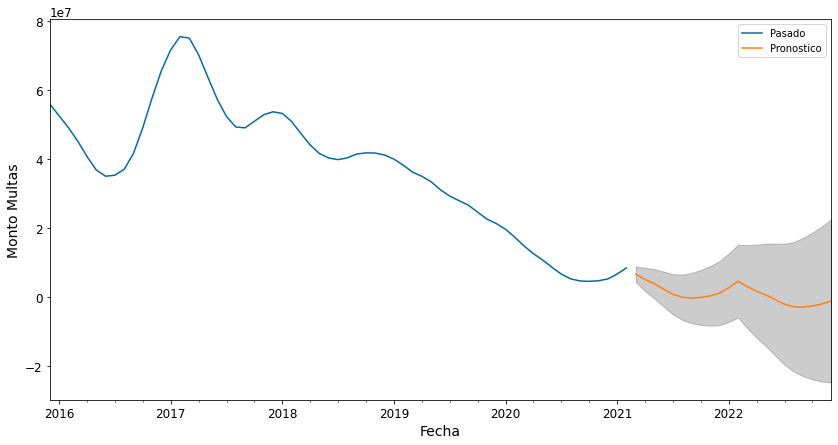

In [154]:
ax = y['2015':].plot(label='observados')
predicciones.predicted_mean.plot(ax=ax, label='Pronóstico con un paso hacia adelante', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='gray',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto')
plt.legend()
plt.show()


prediccion_futuro = results.get_forecast(steps=22)
pred_ci = prediccion_futuro.conf_int()
ax = y.plot(label='Pasado', figsize=(14,7))
prediccion_futuro.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto Multas')
plt.legend()
plt.show()

In [155]:
pred_ci

,lower monto,upper monto
2021-03-01,4.397923e+06,8.968468e+06
2021-04-01,1.800190e+06,8.512609e+06
2021-05-01,-3.591441e+05,8.152348e+06
2021-06-01,-2.729695e+06,7.417910e+06
2021-07-01,-4.982844e+06,6.702105e+06
2021-08-01,-6.614862e+06,6.538818e+06
2021-09-01,-7.544594e+06,7.025546e+06
2021-10-01,-8.030419e+06,7.913612e+06
2021-11-01,-8.259634e+06,9.021877e+06
2021-12-01,-8.136980e+06,1.044973e+07


In [156]:
pred_ci[['lower monto', 'upper monto']].mean(axis=1)

2021-03-01    6.683195e+06
2021-04-01    5.156400e+06
2021-05-01    3.896602e+06
2021-06-01    2.344108e+06
2021-07-01    8.596302e+05
2021-08-01   -3.802213e+04
2021-09-01   -2.595243e+05
2021-10-01   -5.840351e+04
2021-11-01    3.811217e+05
2021-12-01    1.156374e+06
2022-01-01    2.750028e+06
2022-02-01    4.636348e+06
2022-03-01    3.057621e+06
2022-04-01    1.736797e+06
2022-05-01    6.674464e+05
2022-06-01   -7.091816e+05
2022-07-01   -2.032661e+06
2022-08-01   -2.782118e+06
2022-09-01   -2.866221e+06
2022-10-01   -2.536597e+06
2022-11-01   -1.978251e+06
2022-12-01   -1.094124e+06
Freq: MS, dtype: float64

In [157]:
data3= data1[['fecha_de_imposicion', 'monto']]
data3 = data3.sort_values('fecha_de_imposicion')
data3 =data3.set_index('fecha_de_imposicion')
data3['monto'] = data3['monto'].astype('int64')
#data3=data3.dropna()
y=data3['monto'].resample('A').sum()

In [158]:
y=y.head(6)

In [159]:
grafica_montoa_nlavado= pd.DataFrame(data=y)
grafica_montoa_nlavado=grafica_montoa_nlavado.reset_index()
grafica_montoa_nlavado['fecha_de_imposicion'] = grafica_montoa_nlavado['fecha_de_imposicion'].dt.strftime('%Y')

In [160]:


#grafica_montoa_lavado=remove_outlier(grafica_montoa_lavado, 'monto')
pred_ci['monto_mean'] = pred_ci.mean(axis=1)


In [161]:
y

fecha_de_imposicion
2015-12-31    101098041
2016-12-31    120057616
2017-12-31     92293173
2018-12-31     80382367
2019-12-31     41138393
2020-12-31     10644581
Freq: A-DEC, Name: monto, dtype: int64

In [162]:
pred_ci.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2021-03-01 to 2022-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lower monto  22 non-null     float64
 1   upper monto  22 non-null     float64
 2   monto_mean   22 non-null     float64
dtypes: float64(3)
memory usage: 704.0 bytes


In [163]:
pred_ci= pred_ci['monto_mean']

In [164]:
pred_ci

2021-03-01    6.683195e+06
2021-04-01    5.156400e+06
2021-05-01    3.896602e+06
2021-06-01    2.344108e+06
2021-07-01    8.596302e+05
2021-08-01   -3.802213e+04
2021-09-01   -2.595243e+05
2021-10-01   -5.840351e+04
2021-11-01    3.811217e+05
2021-12-01    1.156374e+06
2022-01-01    2.750028e+06
2022-02-01    4.636348e+06
2022-03-01    3.057621e+06
2022-04-01    1.736797e+06
2022-05-01    6.674464e+05
2022-06-01   -7.091816e+05
2022-07-01   -2.032661e+06
2022-08-01   -2.782118e+06
2022-09-01   -2.866221e+06
2022-10-01   -2.536597e+06
2022-11-01   -1.978251e+06
2022-12-01   -1.094124e+06
Freq: MS, Name: monto_mean, dtype: float64

In [165]:
pred_ci= pd.DataFrame(data=pred_ci)

In [166]:
pred_ci['monto_mean']= np.where((pred_ci['monto_mean']< 0), 0, pred_ci['monto_mean'])

In [167]:
pred_grafica_montoa_nlavado=pred_ci['monto_mean'].resample('A').sum()
pred_grafica_montoa_nlavado=pred_grafica_montoa_nlavado.reset_index()

pred_grafica_montoa_nlavado = pred_grafica_montoa_nlavado.rename(columns={'index': 'fecha'})
pred_grafica_montoa_nlavado=pred_grafica_montoa_nlavado[['fecha','monto_mean']]
pred_grafica_montoa_nlavado['monto_mean']=pred_grafica_montoa_nlavado['monto_mean'].astype('int64')
pred_grafica_montoa_nlavado['fecha'] = pred_grafica_montoa_nlavado['fecha'].dt.strftime('%Y')

In [168]:
#fig = go.Figure()
trace0 = go.Bar(x = grafica_montoa_nlavado.fecha_de_imposicion, y=grafica_montoa_nlavado.monto,
                    name='Actual')

trace1= go.Bar(x = pred_grafica_montoa_nlavado.fecha, y=pred_grafica_montoa_nlavado.monto_mean,
                    name='Forecast',) 

layout =go.Layout(title='Aggregate Amount of Non Anti Money Laundering Fines', 
                   xaxis_title='Year',
                   yaxis_title='Amount')

datos = [trace0, trace1]
fig= dict(data=datos, layout=layout)
py.plot(fig, filename = 'Ag_nAML', auto_open=True)

'https://plotly.com/~VictorHdz/30/'

Numero de multas totallllll

In [169]:
data1=data[(data['anio_imposicion']>2014)]
#data1=remove_outlier(data1, 'monto')
data3= data1[['fecha_de_imposicion','monto']]
data3= data3.groupby(data3['fecha_de_imposicion'], as_index=True, sort=True).count()
#data3=remove_outlier(data3, 'monto')
#data3 = data3.sort_values('fecha_de_imposicion')
#data3 =data3.set_index('fecha_de_imposicion')
#data3=data3.dropna()
y=data3['monto'].resample('MS').sum()
#y=y.rolling(12,win_type='triang').sum()
#y=y.dropna()
y

fecha_de_imposicion
2015-01-01    134
2015-02-01    225
2015-03-01    187
2015-04-01    190
2015-05-01    201
             ... 
2020-10-01     21
2020-11-01     22
2020-12-01      8
2021-01-01     58
2021-02-01      2
Freq: MS, Name: monto, Length: 74, dtype: int64

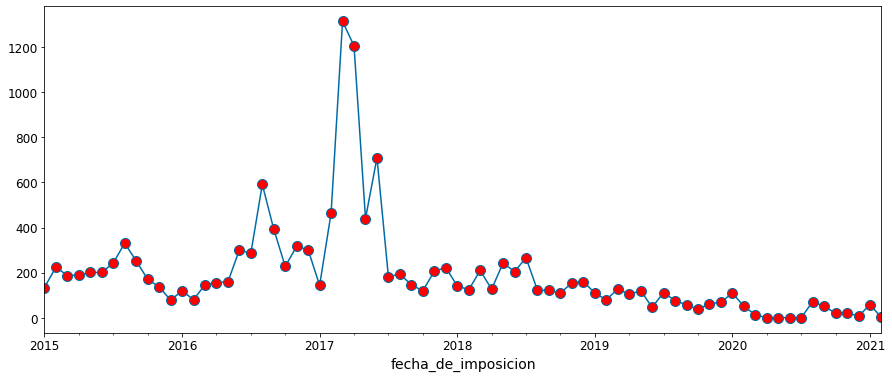

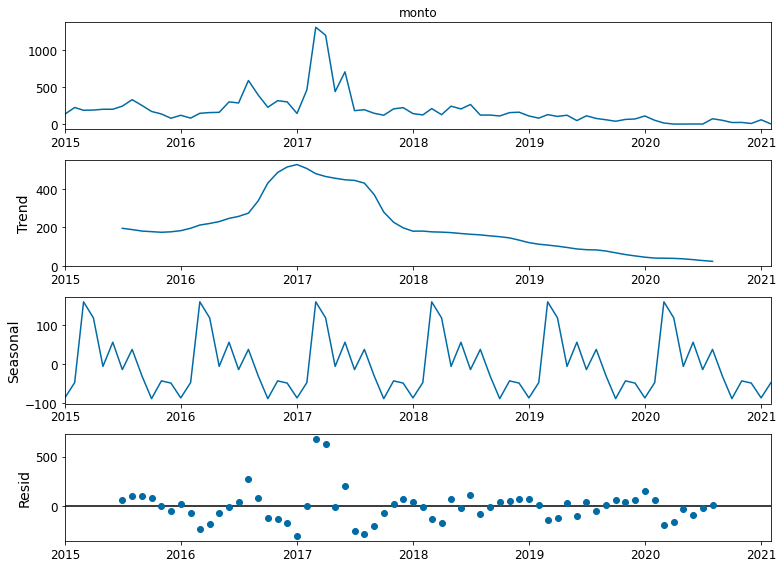

In [170]:
matplotlib.rcParams['axes.labelsize'] =14
matplotlib.rcParams['xtick.labelsize'] =12
matplotlib.rcParams['ytick.labelsize'] =12
fig = plt.figure(facecolor='w')
plt.style.use('tableau-colorblind10')
y.plot(figsize=(15,6),marker="o",markersize=10,markerfacecolor='red')


matplotlib.rcParams['figure.figsize'] =11,8
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig =decomposition.plot()
plt.show()

In [171]:
print(f'Prueba estadistica {dftest[0]}')
print(f'P-value  {dftest[1]}')
for k, v in dftest[4].items():
    print('\t{}:{} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < dftest[0] else "", 100-int(k[:-1])))



Prueba estadistica -10.120083374420764
P-value  9.495643433118396e-18
	1%:-3.431956142626598 Los datos son  estacionarios con 99% de confianza
	5%:-2.862249705862999 Los datos son  estacionarios con 95% de confianza
	10%:-2.5671477833810394 Los datos son  estacionarios con 90% de confianza


In [172]:
dftest = adfuller(data3.monto,autolag=None)
for param in pdq:
    for param_estacionales  in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_estacionales,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMA {param} x {param_estacionales}12 - AIC:{results.aic}')
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:1038.7368943263689
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:868.1307416041305
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:879.3869757979073
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 - AIC:698.7165922865526
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 - AIC:873.4354936614063
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 - AIC:846.7962208037716
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:720.1641885019227
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 - AIC:700.7164163202826
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 - AIC:976.8292597060147
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 - AIC:819.4041083158015
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 - AIC:837.2618023450552
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 - AIC:659.1227352405917
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 - AIC:840.7149596056835
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 - AIC:805.6192875217107
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 - AIC:697.7867773049941
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 - AIC:661.1220933689366
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 - AIC:947.6338962197036
ARIMA (0, 1, 

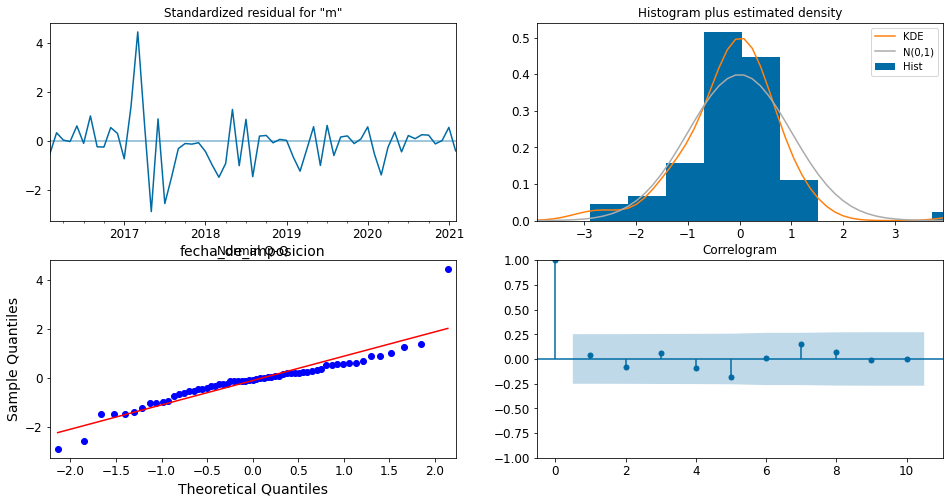

In [173]:
mod = sm.tsa.statespace.SARIMAX(y,
                                            order=(1,1,1),
                                            seasonal_order=(0, 1, 1, 12),
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [174]:
predicciones = results.get_prediction(start=pd.to_datetime('2019-01-01'))
pred_ci = predicciones.conf_int()

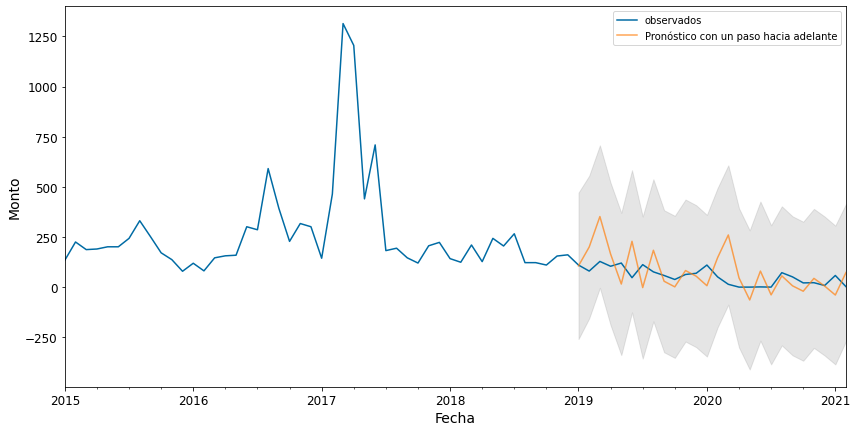

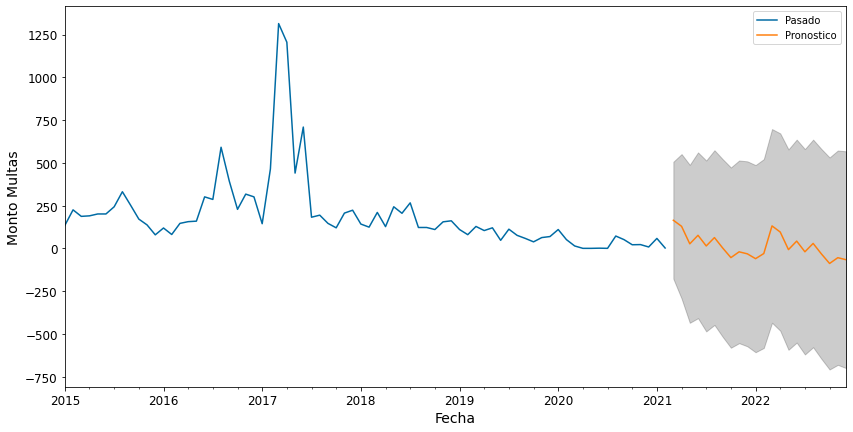

In [175]:
ax = y['2015':].plot(label='observados')
predicciones.predicted_mean.plot(ax=ax, label='Pronóstico con un paso hacia adelante', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='gray',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto')
plt.legend()
plt.show()


prediccion_futuro = results.get_forecast(steps=22)
pred_ci = prediccion_futuro.conf_int()
ax = y.plot(label='Pasado', figsize=(14,7))
prediccion_futuro.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Monto Multas')
plt.legend()
plt.show()

In [176]:

#data1=remove_outlier(data1, 'monto')
data3= data1[['fecha_de_imposicion','monto']]
data3= data3.groupby(data3['fecha_de_imposicion'], as_index=True, sort=True).count()

#data3 = data3.sort_values('fecha_de_imposicion')
#data3 =data3.set_index('fecha_de_imposicion')
#data3=data3.dropna()
y=data3['monto'].resample('MS').sum()
#y=y.rolling(12,win_type='triang').sum()
#y=y.dropna()


In [177]:
pred_ci

,lower monto,upper monto
2021-03-01,-177.645102,506.172198
2021-04-01,-293.463983,551.030783
2021-05-01,-435.300796,488.119254
2021-06-01,-408.297105,560.920654
2021-07-01,-485.608155,513.661961
2021-08-01,-447.673236,573.521960
2021-09-01,-517.321875,521.417996
2021-10-01,-581.120529,472.797739
2021-11-01,-554.261102,513.622744
2021-12-01,-572.692675,508.571007


In [178]:
data1=data[(data['anio_imposicion']>2014)]
#data1=remove_outlier(data1, 'monto')
data3= data1[['fecha_de_imposicion','monto']]
data3= data3.groupby(data3['fecha_de_imposicion'], as_index=True, sort=True).count()

#data3 = data3.sort_values('fecha_de_imposicion')
#data3 =data3.set_index('fecha_de_imposicion')
#data3=data3.dropna()
y=data3['monto'].resample('A').sum()
#y=y.rolling(12,win_type='triang').sum()
#y=y.dropna()


In [179]:
y=y.head(6)

In [180]:
y

fecha_de_imposicion
2015-12-31    2351
2016-12-31    3078
2017-12-31    5347
2018-12-31    1987
2019-12-31    1005
2020-12-31     350
Freq: A-DEC, Name: monto, dtype: int64

In [181]:
grafica_num= pd.DataFrame(data=y)
grafica_num=grafica_num.reset_index()
grafica_num['fecha_de_imposicion'] = grafica_num['fecha_de_imposicion'].dt.strftime('%Y')

In [182]:
pred_ci['monto_mean'] = pred_ci.mean(axis=1)


In [183]:
pred_ci= pred_ci['monto_mean']
pred_ci= pd.DataFrame(data=pred_ci)
pred_ci['monto_mean']= np.where((pred_ci['monto_mean']< 0), 0, pred_ci['monto_mean'])

In [184]:
pred_grafica_num=pred_ci['monto_mean'].resample('A').sum()
pred_grafica_num=pred_grafica_num.reset_index()

pred_grafica_num = pred_grafica_num.rename(columns={'index': 'fecha'})
pred_grafica_num=pred_grafica_num[['fecha','monto_mean']]
pred_grafica_num['monto_mean']=pred_grafica_num['monto_mean'].astype('int64')
pred_grafica_num['fecha'] = pred_grafica_num['fecha'].dt.strftime('%Y')

In [185]:
trace0 = go.Bar(x = grafica_num.fecha_de_imposicion, y=grafica_num.monto,
                    name='Actual')

trace1= go.Bar(x = pred_grafica_num.fecha, y=pred_grafica_num.monto_mean,
                    name='Forecast',) 

layout =go.Layout(title='Number of Fines', 
                   xaxis_title='Year',
                   yaxis_title='No. of Fines')

datos = [trace0, trace1]
fig= dict(data=datos, layout=layout)
py.plot(fig, filename = 'number', auto_open=True)


'https://plotly.com/~VictorHdz/42/'